In [1]:
import pandas as pd
import numpy as np
from env import get_db_url
import wrangle_zillow
import model
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.cluster import KMeans
alpha = 0.05
rcParams['figure.figsize'] = 16,8
sns.set(font_scale=1.5)

In [2]:
df = wrangle_zillow.wrangle_zillow()
df = wrangle_zillow.handle_missing_zillow_values(df)
df = wrangle_zillow.remove_outliers(df, 3.0, ['bathroom', 'bedroom','square_feet','lot_size','tax_value'])

Using cached data
Shape before handling missing values: (77380, 61)
For threshold based dropping: 
(52463, 61)  original shape
(52463, 59)  shape after dropping columns with prop required rows below theshold
(52463, 59)  shape after dropping rows with prop required columns below threshold
Shape after removing nulls: (50906, 53)
Number of observations removed: 4545


In [3]:
train, validate, test = wrangle_zillow.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [4]:
train, validate, test = model.add_features(train, validate, test)

Initially examine correlations between variables and target. No variables showed strong positive or weak correlation.

In [5]:
# No values show any significant correlation with logerror right off the bat
train.corrwith(train.abs_logerror).sort_values(ascending=False)[2:].head(10)

age                     0.096562
is_tax_delinquent       0.057685
has_old_heat            0.057519
taxdelinquencyyear      0.052777
is_la                   0.032553
regionidcounty          0.028588
tax_rate                0.026136
bed_bath_ratio          0.025916
land_dollar_per_sqft    0.014003
lot_size                0.013878
dtype: float64

### Which categorical features have statistically significant absolute log errors greater than the overall mean?

In [6]:
overall_mean = train.abs_logerror.mean()
high_cols =[]
high_option = []
high_difference = []
option_means = []
option_sample_size=[]

# print(f"Overall mean logerror: {overall_mean}")
for col in train.columns:
    if train[col].nunique()<10:
        for option in train[col].unique():
            if len(train[train[col]==option].abs_logerror)>2:
                t, p = stats.ttest_1samp(train[train[col]==option].abs_logerror, train.abs_logerror.mean())
                if p<alpha:
                    sample_mean = train[train[col]==option].abs_logerror.mean()
                    difference = sample_mean - overall_mean
                    sample_size = len(train[train[col]==option].logerror)
                    # print(f"For {col} - {option} the mean ({sample_mean:.4f}) differs significantly from overall mean by {difference:.4f}, sample size {len(train[train[col]==option].logerror)}")
                    
                    # Only saving those values with greater than average absolute log errors and decent sampel
                    if (difference>0) and (sample_size>100):
                        high_cols.append(col)
                        high_option.append(option)
                        high_difference.append(difference)
                        option_means.append(sample_mean)
                        option_sample_size.append(len(train[train[col]==option].logerror))

high_log_errors = pd.DataFrame(data = {'column':high_cols,
                                      'option': high_option,
                                      'mean_abs_log_error': option_means,
                                      'difference_from_overall': high_difference,
                                      'option_sample_size':option_sample_size}).sort_values('difference_from_overall',ascending=False)
# Combine column name and option name
high_log_errors["column_option"] = high_log_errors.column.astype(str)+"-"+(high_log_errors.option.astype(str))

Text(0, 0.5, 'Feature')

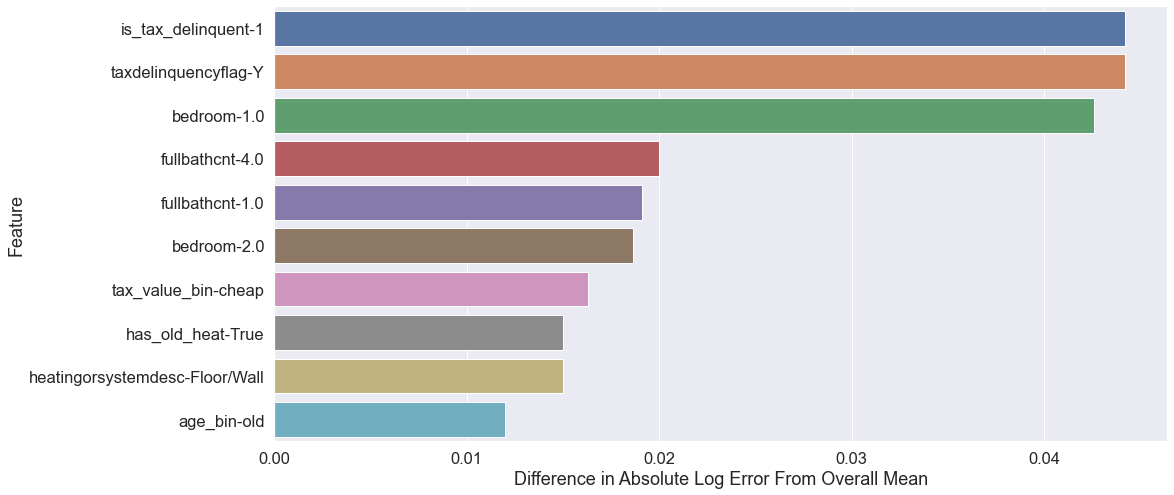

In [7]:
sns.barplot(data = high_log_errors.head(10), y = 'column_option', x = 'difference_from_overall')
plt.xlabel('Difference in Absolute Log Error From Overall Mean')
plt.ylabel('Feature')

### Looking for clusters in the top values:
- Old, Small, low tax value houses with outdated heating systems (age, square feet, tax value, heating system)
- Cheap structure and land valued homes (structure dollar per sqft, land dollar per sqft)
- High full bath counts and high bed to bath houses 
- Tax delinquent, smaller bathrooms counts (2 or less), cheaper tax values

In [8]:
# Scale required columns
train_scaled, validate_scaled, test_scaled = model.scale_data(train, validate, test, ['age','square_feet','tax_value','structure_dollar_per_sqft','land_dollar_per_sqft','fullbathcnt','bed_bath_ratio','bathroom'])

In [9]:
features_to_cluster = ['age_scaled','square_feet_scaled','tax_value_scaled','has_old_heat']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster, plots = False)

Overall mean logerror: 0.06905191781502365


Text(0.5, 0, '')

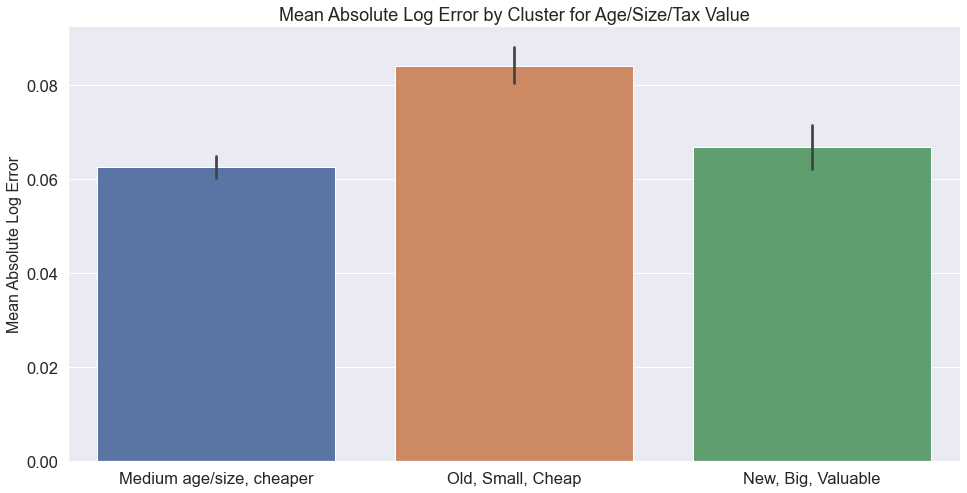

In [10]:
rename_dict = {0:'New, Big, Valuable', 1:'Old, Small, Cheap', 2:'Medium age/size, cheaper'}
train_scaled = train_scaled.replace({'age_squ_tax_has_cluster':rename_dict})

sns.barplot(data = train_scaled, x = 'age_squ_tax_has_cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Age/Size/Tax Value")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)

## Three cluster identified as:
- 0: New, Big, High Tax Value, Newer heat
- 1: Old, Small, Low Tax Value, Older heat ----> This cluster had higher than average absolute log error
- 2: Medium age, Medium size, Lower tax value, Newer heat

In [11]:
train_scaled.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

In [15]:
train_scaled.is_tax_delinquent.value_counts()

0    24949
1     1012
Name: is_tax_delinquent, dtype: int64

In [16]:
features_to_cluster = ['structure_dollar_per_sqft','land_dollar_per_sqft','is_tax_delinquent']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster, cluster_qty = 5, plots=False)

Overall mean logerror: 0.06905191781502365


In [18]:
train_scaled.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

Text(0.5, 0, '')

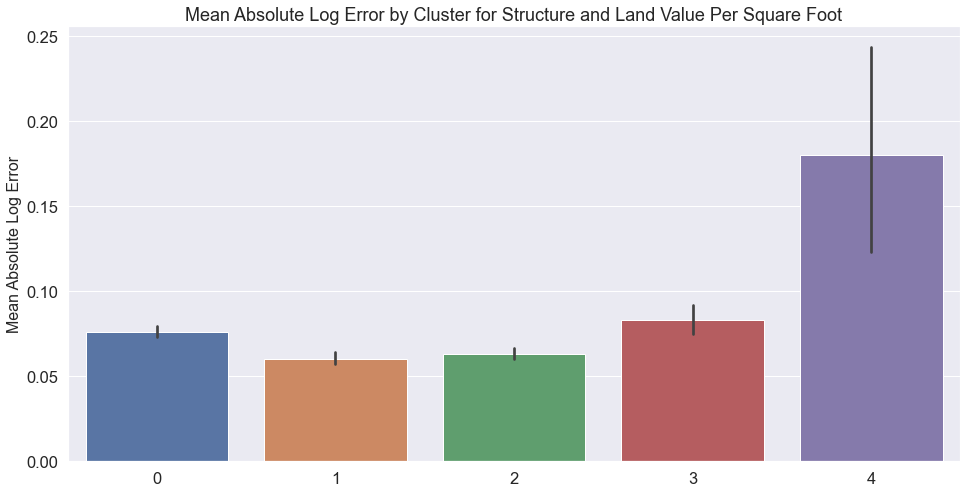

In [19]:
# rename_dict = {0:'Lowest Value', 1:'Medium Value', 2:'Low Value', 3: 'High Value', 4: 'Very High Value'}
# train_scaled = train_scaled.replace({'str_lan_cluster':rename_dict}).sort_values(by='structure_dollar_per_sqft')
sns.barplot(data = train_scaled, x = 'str_lan_is__cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Structure and Land Value Per Square Foot")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)

In [21]:
train_scaled.groupby('str_lan_is__cluster').mean()[['structure_dollar_per_sqft','land_dollar_per_sqft','abs_logerror','is_tax_delinquent']]

,structure_dollar_per_sqft,land_dollar_per_sqft,abs_logerror,is_tax_delinquent
str_lan_is__cluster,,,,
0,93.786643,36.837658,0.075992,0.044403
1,378.859483,280.073895,0.060382,0.036113
2,242.427599,147.128018,0.063296,0.034468
3,627.209001,494.591573,0.083057,0.036481
4,1255.976614,1034.383677,0.180114,0.102941


## High structure and land values result in higher absolute log errors